In [2]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [3]:
%%time

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}

days = 14
num_timesteps = 24 * days
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}

initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    #     speculators # folks speculating on clover coin price
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f91fd4320f0>]
CPU times: user 54min 16s, sys: 46.5 s, total: 55min 3s
Wall time: 55min 1s


In [5]:
%%time

def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        substep = row['substep']
        run = row['run']
        s = row['s']
        g = s['network']
        new_cols = {}

        
        players = utils.get_nodes_by_type(g, 'player')
        clovers = utils.get_nodes_by_type(g, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward

        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(s['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)

# adding new useful columns for graphing
full_df['coin-price'] = utils.calculateCurrentPrice(
    (full_df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (full_df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

full_df['market-cap'] = full_df['coin-price'] * full_df['bc-totalSupply'] * 250


full_df

CPU times: user 1min 56s, sys: 58.1 ms, total: 1min 56s
Wall time: 1min 56s


In [6]:
df = full_df[full_df['substep'] == 2] # after player policy

df

,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,players,reward-rotSym,reward-x0Sym,reward-xnySym,reward-xySym,...,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price,market-cap
2,134,40.006530,30355.317667,137,137,66,1.675000,1.340000,0.227119,0.291304,...,7,1,2,1,9,58,45,14,0.001680,12750.679958
5,220,40.432812,30412.258748,270,270,66,2.363636,1.040000,0.252427,0.260000,...,10,1,2,2,24,102,99,24,0.001689,12843.577970
8,281,40.972843,30475.376920,405,405,66,2.456250,1.034211,0.245625,0.271034,...,15,1,2,3,37,159,144,37,0.001701,12958.610612
11,413,40.812250,30550.068885,540,540,66,2.092000,0.986792,0.250239,0.284239,...,24,1,2,4,52,208,183,55,0.001696,12954.753040
14,481,41.462119,30612.752566,681,681,66,2.193333,1.028125,0.245522,0.288596,...,29,1,2,5,63,267,227,71,0.001710,13089.341386
17,587,41.652132,30679.000674,811,811,66,2.180556,1.006410,0.247634,0.291822,...,35,1,2,6,77,316,268,88,0.001714,13144.474500
20,717,41.572394,30743.845198,943,943,66,2.231707,0.943299,0.246631,0.296117,...,40,1,2,7,96,370,308,100,0.001711,13151.661495
23,850,41.386177,30812.102458,1076,1076,66,2.181250,0.934821,0.248104,0.295763,...,47,1,2,8,111,421,353,114,0.001706,13141.085779
26,968,41.507256,30884.563120,1221,1221,66,2.167273,0.916923,0.248852,0.299497,...,54,1,2,9,129,478,397,133,0.001708,13186.125650
29,962,42.952557,30944.243742,1359,1359,66,2.244068,0.919444,0.247940,0.300909,...,58,1,2,10,143,533,439,150,0.001740,13461.748266


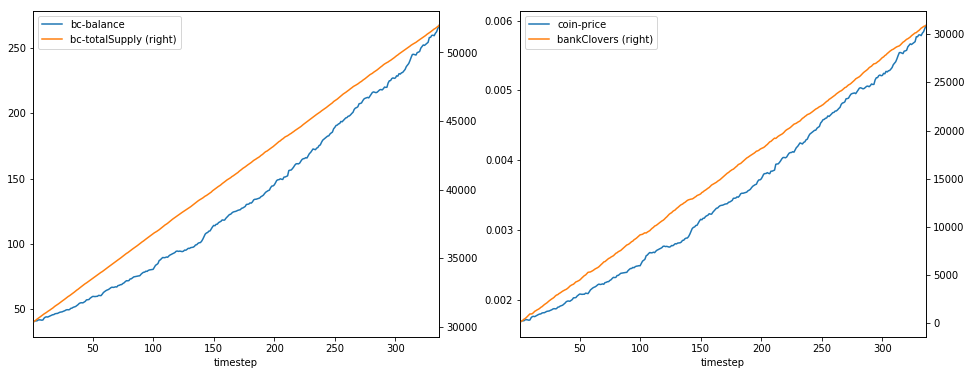

In [7]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[run,1])

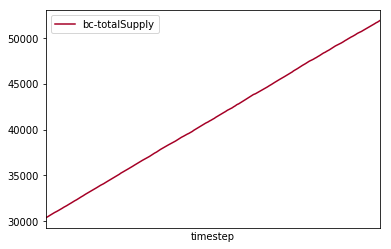

In [8]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn',
       )

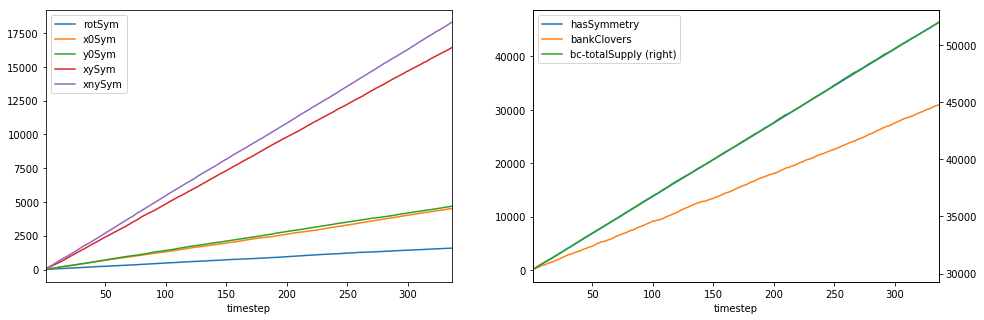

In [9]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

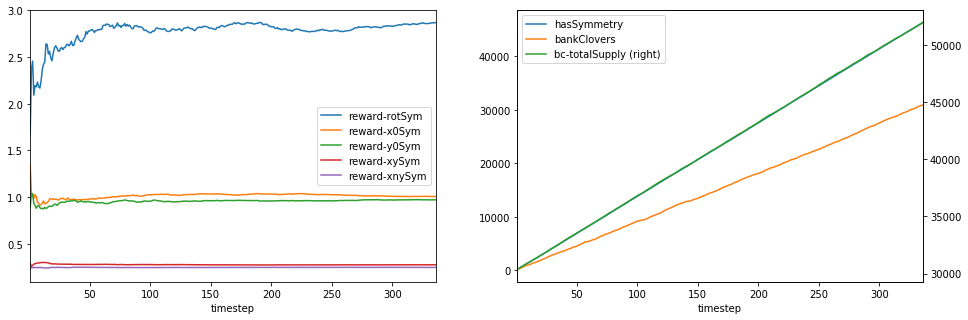

In [10]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

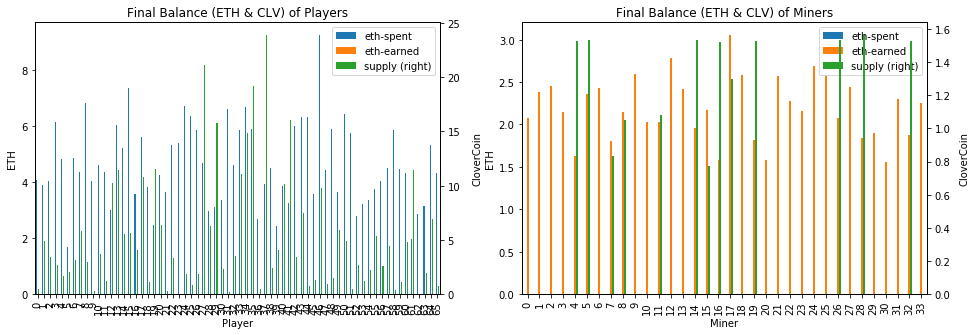

In [11]:
final_state = raw_result[-1]['s']
g = final_state['network']
miners = utils.get_nodes_by_type(g, 'miner')
players = utils.get_nodes_by_type(g, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(16,(row_height*num_runs)))
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if num_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if num_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
        pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])

Text(0.5, 51.0, 'Timestep')

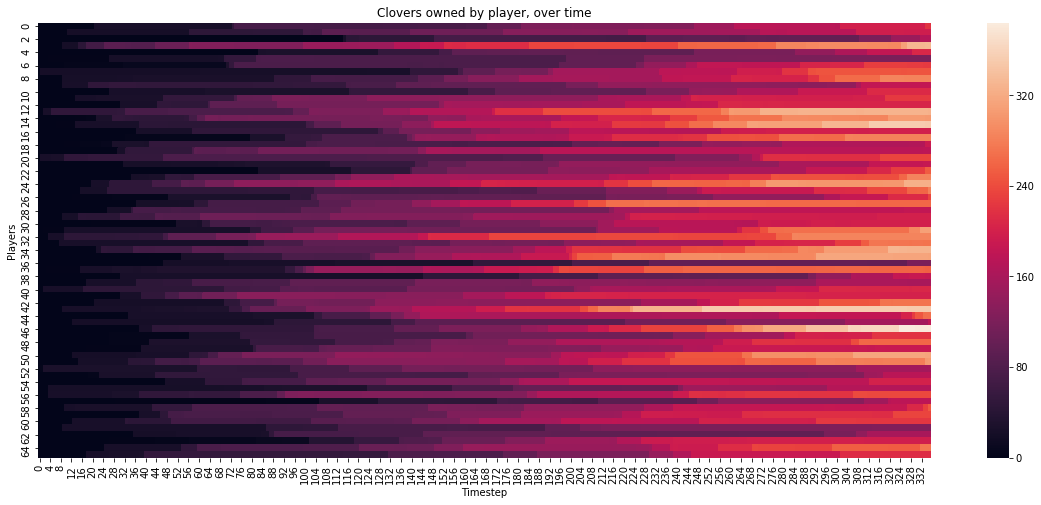

In [12]:
players = utils.get_nodes_by_type(raw_result[1]['s']['network'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = len(list(g.successors(i_ind)))

dims = (20, 8)
# adjust the dimensions

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

Text(0.5, 24.0, 'Timestep')

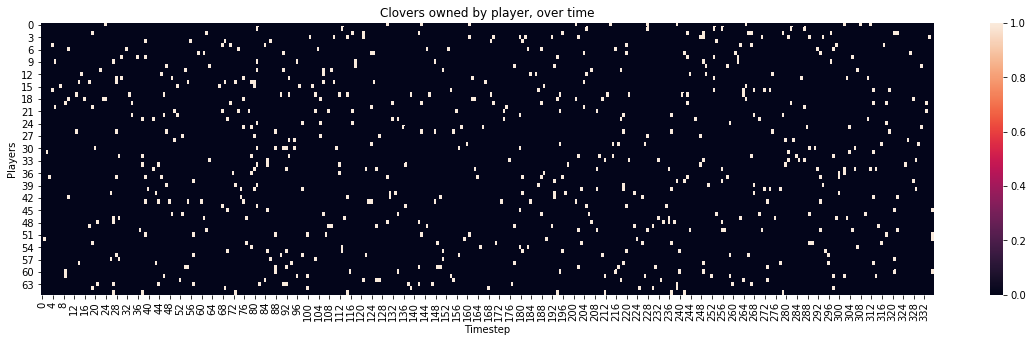

In [13]:
players = utils.get_nodes_by_type(raw_result[1]['s']['network'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = g.nodes[i_ind]['is_active']

dims = (20, 5)

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

In [31]:
#raw_result

In [14]:



pdf

,cash_out_threshold,eth-earned,eth-spent,hashrate,is_active,supply,type
0,0.01,2.074586,0,14.482563,0.7,0.000000,miner
1,0.01,2.383886,0,16.524429,0.7,0.000000,miner
2,0.01,2.451489,0,17.092733,0.7,0.000000,miner
3,0.01,2.145287,0,14.719713,0.7,0.000000,miner
4,0.01,1.628852,0,11.291743,0.7,1.526927,miner
5,0.01,2.363846,0,16.131996,0.7,1.533887,miner
6,0.01,2.430072,0,17.346217,0.7,0.000000,miner
7,0.01,1.808586,0,13.157160,0.7,0.831101,miner
8,0.01,2.151189,0,15.089073,0.7,1.051390,miner
9,0.01,2.593661,0,18.172267,0.7,0.000000,miner


In [15]:
g = raw_result[60]['network']

clovers = utils.get_nodes_by_type(g, 'clover')

g.nodes[clovers[5]]

p = g.nodes[5]

KeyError: 'network'

In [21]:
p['newField'] = 23

In [22]:
p

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [23]:
g.nodes[5]

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [7]:
clovers = [{'me': 'you'}, {'me': 'other'}, {'you': 'me'}]

In [8]:
[foo for foo in clovers if foo['me'] == 'you']

KeyError: 'me'

In [10]:
from scipy.stats import norm

norm.interval(0.999)

(-3.2905267314918945, 3.2905267314919255)

NameError: name 'g' is not defined

In [38]:
import networkx as nx
g = nx.DiGraph()

for i in range(5):
    g.add_node(i)
    
g.add_edge(2,3)
g.add_edge(1,3)
g.add_edge(1,2)
print("original edges:")
for i in g.edges():
    print(i)

ebunch = list(g.edges(1))
g.remove_edges_from(ebunch)
    
print("new edges:")
for i in g.edges():
    print(i)

original edges:
(1, 3)
(1, 2)
(2, 3)
new edges:
(2, 3)


In [34]:
ebunch = g.edges(1)

g.remove_edges_from(ebunch)

NameError: name 'g' is not defined

In [36]:
g.edges(1)

OutEdgeDataView([])

In [105]:
from numpy.random import rand
import numpy as np
from scipy.stats import norm

cloverObjValue = 0
stdDev = 1
playerId = 20
cloverId = 5
np.random.seed([playerId,cloverId])
norm.rvs(loc=cloverObjValue,scale=stdDev)

-0.3875415218651566

In [82]:
rand()

0.6221087710398319

In [46]:
{"foo": "bar", "clover": "other"}

{'foo': 'bar', 'clover': 'other'}

In [25]:
raw_result[30]

{'s': {'bc-balance': 62.06655250377233,
  'bc-totalSupply': 32183.32228269765,
  'symmetries': {'hasSymmetry': 357,
   'rotSym': 8,
   'y0Sym': 35,
   'x0Sym': 40,
   'xySym': 140,
   'xnySym': 129},
  'network': <networkx.classes.digraph.DiGraph at 0x7f30fa2691d0>},
 'run': 1,
 'substep': 1,
 'timestep': 30}

In [28]:
def test_function():
    s = raw_result[30]
    _input = policies.player_policy([params], None, None, s)
    return state_updates.update_state(None, None, None, s, _input)

%lprun -f utils.processBuysAndSells test_function()

In [33]:
foo = {'me': 2}

if 'me' in foo:
    print(1)

1
